# Sample Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-08 04:06:07--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  19.8MB/s    in 0.7s    

2022-01-08 04:06:08 (19.8 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-08 04:06:08--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  14.9MB/s    in 0.7s    

202

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [6]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

In [7]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## 產生推薦

In [103]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender(training_data, users=[], k=10, start_date=''):
    if start_date != '':
        training_data = training_data[
            training_data['DATE'] > start_date
        ]
    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation

## 結果評估

In [104]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

In [55]:
import pandas
sdate = '15/2/2018'
edate = '31/5/2018'
date_for_test = pandas.date_range(sdate, edate)

In [56]:
recall_data = {}
for date in date_for_test:
    ratings_by_user = recommender(ratings_trainings, users, k=10, start_date=date)
    recall = evaluate(ratings_testings_by_user, ratings_by_user)
    recall_data[date] = recall

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

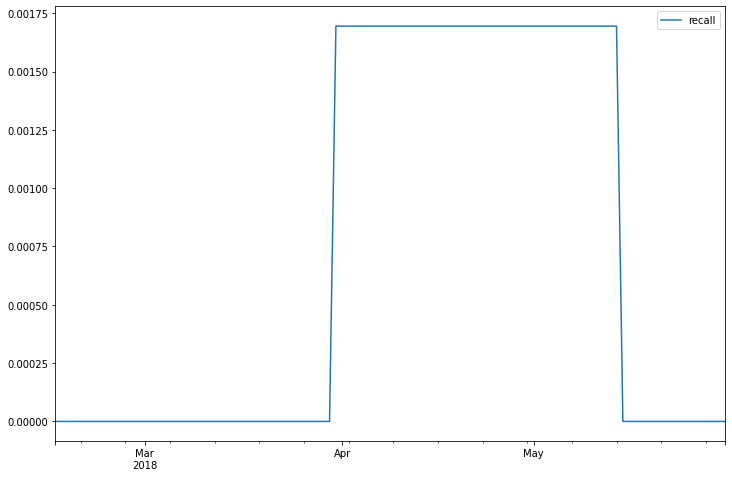

In [98]:
df = pd.DataFrame.from_dict(recall_data, orient='index', columns=['recall'])
df.plot(figsize=(12,8))